# Stock Price Forecasting with LSTMs

In this tutorial we are going to show how a simple LSTM can predict stock prices in the short term. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
import tensorflow as tf
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/Users/miguel/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


OS:  darwin
Python:  3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 18:11:28) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Keras:  2.1.5
Tensorflow:  1.5.0
Numpy:  1.14.1
Number of CPU processors:  8


In [2]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step

In [3]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


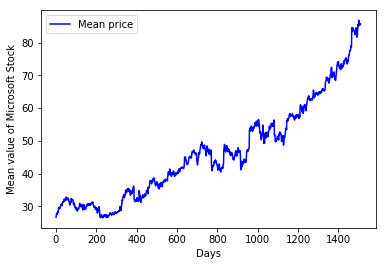

In [4]:
mean_price = df.mean(axis = 1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

In [6]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [7]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)

In [9]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(10, input_shape=(1, time_ahead)))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(10, input_shape=(1, time_ahead))))
    elif model_name == 'GRU':
        model.add(GRU(10, input_shape=(1, time_ahead)))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

In [10]:
model = create_symbol(model_name='LSTM', units=10, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

In [11]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/5
 - 3s - loss: 0.0065
Epoch 2/5
 - 2s - loss: 1.0402e-04
Epoch 3/5
 - 2s - loss: 8.6956e-05
Epoch 4/5
 - 2s - loss: 8.9224e-05
Epoch 5/5
 - 3s - loss: 9.1966e-05


In [12]:
pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
y_test = scaler.inverse_transform([y_test])
score = math.sqrt(mean_squared_error(y_test[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

Test RMSE: 0.67


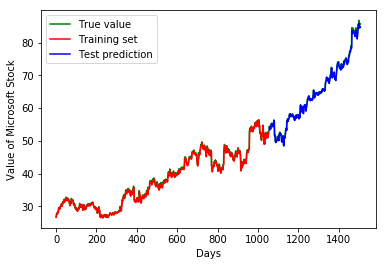

In [13]:
mean_price = scaler.inverse_transform(mean_price)
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       xlabel='Days', ylabel='Value of Microsoft Stock', 
                       color=['g','r','b'], legend=['True value','Training set','Test prediction'])